# 🔍 Detección de Anomalías Mejorada - JUNTA ANALYTICS

**Versión mejorada** del entrenamiento de detección de anomalías con:
- Anomalías sintéticas más realistas
- Características mejoradas específicas del medidor
- Mejor detección de patrones anómalos

In [2]:
import sys
import os
from datetime import datetime
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from ml_models.anomaly_detector import AnomalyDetector

sns.set_palette("husl")
plt.style.use("seaborn-v0_8")

DATA_DIR = "../data/processed"
MODELS_DIR = "../data/models"
MODEL_NAME = "anomaly_detector_improved.joblib"
os.makedirs(MODELS_DIR, exist_ok=True)

print("="*72)
print("JUNTA ANALYTICS - DETECCIÓN DE ANOMALÍAS MEJORADA")
print(f"Fecha de ejecución: {datetime.now():%Y-%m-%d %H:%M}")
print("="*72)

JUNTA ANALYTICS - DETECCIÓN DE ANOMALÍAS MEJORADA
Fecha de ejecución: 2025-05-25 21:11


## 📊 Carga de Datos

In [3]:
# Carga de datasets procesados
individual_df = pd.read_csv(
    os.path.join(DATA_DIR, "individual_consumption.csv"),
    parse_dates=["created_at", "period_start", "period_end"],
)
merged_df = pd.read_csv(
    os.path.join(DATA_DIR, "merged_rainfall_consumption.csv"),
    parse_dates=["period_dt"],
)
merged_df["period_str"] = merged_df["period_dt"].dt.to_period("M").astype(str)

print(f"Lecturas individuales   : {len(individual_df):,}")
print(f"Registros clima+consumo : {len(merged_df):,}")
print(f"Medidores únicos        : {individual_df['water_meter_id'].nunique():,}")
print(f"Vecindarios únicos      : {individual_df['neighborhood_id'].nunique() if 'neighborhood_id' in individual_df.columns else 'N/A'}")

Lecturas individuales   : 10,067
Registros clima+consumo : 29
Medidores únicos        : 362
Vecindarios únicos      : 7


## 🎯 Preparación de Datos de Entrenamiento

In [4]:
# Selección de datos para entrenamiento (más conservador)
cut_start = individual_df["period_start"].quantile(0.15)
cut_end   = individual_df["period_start"].quantile(0.85)

train_df = individual_df.query(
    "@cut_start <= period_start <= @cut_end"
).copy()

# Limpieza más estricta
print(f"Datos antes de limpieza: {len(train_df):,}")

train_df = train_df.dropna(subset=["total_consumed", "water_meter_id"])
train_df = train_df[train_df["total_consumed"] >= 0]
train_df = train_df[train_df["total_consumed"] <= 1000]  # Filtrar consumos extremadamente altos
train_df["days_billed"].fillna(30, inplace=True)

# Solo medidores con al menos 3 lecturas
meter_counts = train_df["water_meter_id"].value_counts()
valid_meters = meter_counts[meter_counts >= 3].index
train_df = train_df[train_df["water_meter_id"].isin(valid_meters)]

print(f"Datos después de limpieza: {len(train_df):,}")
print(f"Período entrenamiento: {cut_start.date()} → {cut_end.date()}")
print(f"Medidores válidos: {len(valid_meters):,}")

Datos antes de limpieza: 7,264
Datos después de limpieza: 7,261
Período entrenamiento: 2023-04-02 → 2024-12-01
Medidores válidos: 354


## 🤖 Entrenamiento con Algoritmo Mejorado

In [5]:
# Entrenamiento con anomalías sintéticas mejoradas
detector = AnomalyDetector(contamination=0.05, random_state=42)  # Aumentamos contaminación

print("🔄 Entrenando modelo con anomalías sintéticas...")
metrics_val = detector.train(
    train_df,
    climate_df=merged_df,
    use_synthetic=True,
)

print("\n📊 Métricas de validación (con sintéticos mejorados):")
for k, v in metrics_val.items():
    if isinstance(v, float):
        print(f"  {k:12}: {v:.4f}")
    else:
        print(f"  {k:12}: {v}")

print(f"\n🔧 Características utilizadas: {len(detector.feature_columns_)}")
print("Top características:")
for i, feat in enumerate(detector.feature_columns_[:10]):
    print(f"  {i+1:2d}. {feat}")

🔄 Entrenando modelo con anomalías sintéticas...


/Users/luispillaga/Personal/junta/junta-analytics/notebooks/../ml_models/anomaly_detector.py:295: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15.611384301371277' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_syn.at[i, "total_consumed"] *= mult



📊 Métricas de validación (con sintéticos mejorados):
  precision   : 0.1983
  recall      : 0.3692
  f1          : 0.2581
  auc         : 0.7975
  threshold   : -0.0338

🔧 Características utilizadas: 22
Top características:
   1. total_consumed
   2. consumption_per_day
   3. log_consumption
   4. log_consumption_per_day
   5. z_meter
   6. meter_percentile
   7. mad_meter
   8. consumption_ratio
   9. is_zero_consumption
  10. is_very_high


## 💾 Entrenamiento Final y Guardado

In [6]:
# Re-entrenamiento final sin sintéticos
print("🔄 Re-entrenando modelo final sin sintéticos...")
_ = detector.train(train_df, climate_df=merged_df, use_synthetic=False)

model_path = os.path.join(MODELS_DIR, MODEL_NAME)
detector.save(model_path)
print(f"\n✅ Modelo mejorado guardado → {model_path}")

🔄 Re-entrenando modelo final sin sintéticos...


/Users/luispillaga/.pyenv/versions/3.10.16/envs/junta-analytics/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/luispillaga/.pyenv/versions/3.10.16/envs/junta-analytics/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/luispillaga/.pyenv/versions/3.10.16/envs/junta-analytics/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/luispillaga/.pyenv/versions/3.10.16/envs/junta-analytics/lib/python3.10/site-packages


✅ Modelo mejorado guardado → ../data/models/anomaly_detector_improved.joblib


## 📈 Análisis de Distribución de Scores

/var/folders/_k/h_t0hvh916nfgnc1vbq_3z3m0000gn/T/ipykernel_34153/4115879739.py:32: UserWarning: Glyph 8658 (\N{RIGHTWARDS DOUBLE ARROW}) missing from current font.
  plt.tight_layout()
/Users/luispillaga/.pyenv/versions/3.10.16/envs/junta-analytics/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8658 (\N{RIGHTWARDS DOUBLE ARROW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


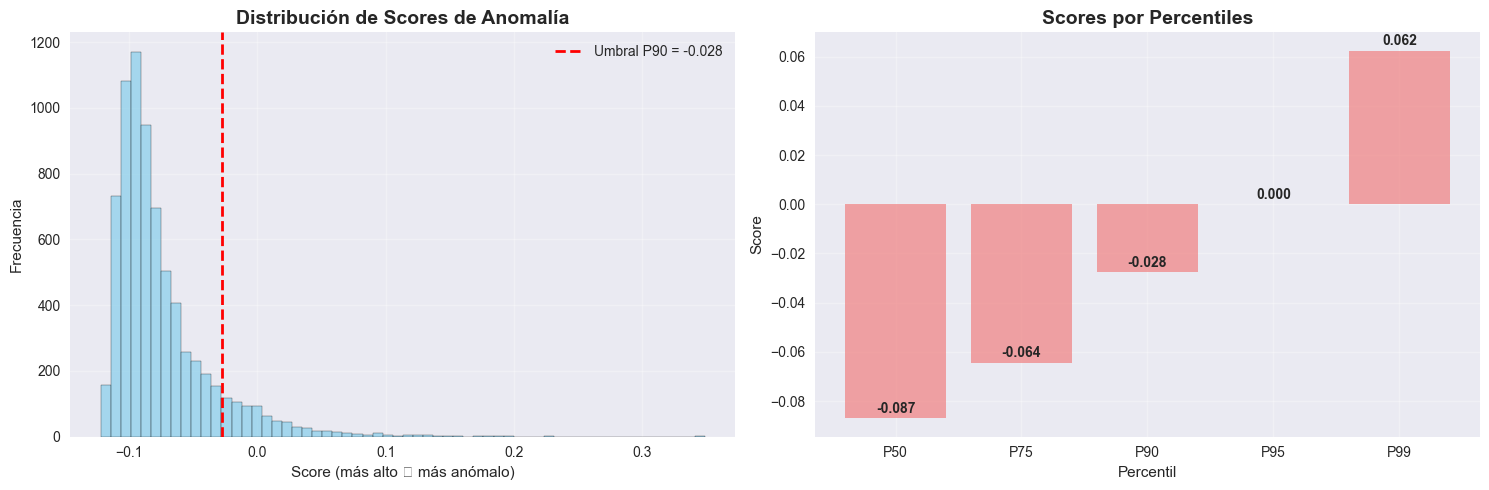


📊 Estadísticas de scores:
  Media    : -0.0757
  Desv.Est.: 0.0377
  Min      : -0.1224
  Max      : 0.3493
  Anomalías detectadas: 726 (10.0%)


In [7]:
# Histograma de puntuaciones mejorado
X_feats = detector._build_features(train_df)
scores  = -detector.pipeline_.decision_function(X_feats)
thr     = detector.score_threshold_

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histograma principal
ax1.hist(scores, bins=60, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(thr, color="red", linestyle="--", linewidth=2, label=f"Umbral P90 = {thr:.3f}")
ax1.set_title("Distribución de Scores de Anomalía", fontsize=14, fontweight='bold')
ax1.set_xlabel("Score (más alto ⇒ más anómalo)")
ax1.set_ylabel("Frecuencia")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Box plot por percentiles
percentiles = [50, 75, 90, 95, 99]
perc_scores = [np.percentile(scores, p) for p in percentiles]
ax2.bar(range(len(percentiles)), perc_scores, color='lightcoral', alpha=0.7)
ax2.set_title("Scores por Percentiles", fontsize=14, fontweight='bold')
ax2.set_xlabel("Percentil")
ax2.set_ylabel("Score")
ax2.set_xticks(range(len(percentiles)))
ax2.set_xticklabels([f"P{p}" for p in percentiles])
ax2.grid(True, alpha=0.3)

# Añadir valores en las barras
for i, v in enumerate(perc_scores):
    ax2.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Estadísticas de scores:")
print(f"  Media    : {scores.mean():.4f}")
print(f"  Desv.Est.: {scores.std():.4f}")
print(f"  Min      : {scores.min():.4f}")
print(f"  Max      : {scores.max():.4f}")
print(f"  Anomalías detectadas: {(scores > thr).sum():,} ({(scores > thr).mean()*100:.1f}%)")

## 🧪 Pruebas del Modelo Mejorado

In [8]:
# Casos de prueba más realistas
test_cases = [
    {
        "name": "Consumo Normal",
        "water_meter_id": train_df["water_meter_id"].iloc[0],
        "current_reading": 1050,
        "previous_reading": 1020,  # 30 unidades en 30 días = 1 por día
        "days_billed": 30
    },
    {
        "name": "Consumo Alto (Posible Fuga)",
        "water_meter_id": train_df["water_meter_id"].iloc[10],
        "current_reading": 1200,
        "previous_reading": 1050,  # 150 unidades en 30 días = 5 por día
        "days_billed": 30
    },
    {
        "name": "Consumo Cero (Medidor Roto)",
        "water_meter_id": train_df["water_meter_id"].iloc[20],
        "current_reading": 1000,
        "previous_reading": 1000,  # 0 unidades
        "days_billed": 30
    },
    {
        "name": "Lectura Incorrecta (Negativa)",
        "water_meter_id": train_df["water_meter_id"].iloc[30],
        "current_reading": 980,
        "previous_reading": 1000,  # Lectura menor que anterior
        "days_billed": 30
    },
    {
        "name": "Consumo Extremo (Spike)",
        "water_meter_id": train_df["water_meter_id"].iloc[40],
        "current_reading": 1500,
        "previous_reading": 1000,  # 500 unidades en 30 días = 16.67 por día
        "days_billed": 30
    }
]

print("🧪 Pruebas del Modelo Mejorado:\n")
for i, case in enumerate(test_cases, 1):
    result = detector.detect_single_reading(
        case["water_meter_id"],
        case["current_reading"],
        case["previous_reading"],
        case["days_billed"],
        train_df
    )
    
    print(f"{i}. {case['name']}:")
    print(f"   Consumo: {result['total_consumed']} unidades ({result['consumption_per_day']:.2f}/día)")
    print(f"   Anomalía: {'🚨 SÍ' if result['is_anomaly'] else '✅ NO'}")
    print(f"   Score: {result['score']:.4f} | Confianza: {result['confidence']:.2f}")
    print(f"   Razón: {result['reason']}")
    print()

🧪 Pruebas del Modelo Mejorado:

Anomaly detected: True
Score: 0.0434930591127064
Confidence: 0.0
1. Consumo Normal:
   Consumo: 30 unidades (1.00/día)
   Anomalía: 🚨 SÍ
   Score: 0.0435 | Confianza: 0.00
   Razón: Patrón de consumo anómalo detectado

Anomaly detected: True
Score: 0.2229689718534804
Confidence: 0.0
2. Consumo Alto (Posible Fuga):
   Consumo: 150 unidades (5.00/día)
   Anomalía: 🚨 SÍ
   Score: 0.2230 | Confianza: 0.00
   Razón: Patrón de consumo anómalo detectado

Anomaly detected: True
Score: 0.010048427951488303
Confidence: 0.0
3. Consumo Cero (Medidor Roto):
   Consumo: 0 unidades (0.00/día)
   Anomalía: 🚨 SÍ
   Score: 0.0100 | Confianza: 0.00
   Razón: Consumo cero detectado

4. Lectura Incorrecta (Negativa):
   Consumo: -20 unidades (0.00/día)
   Anomalía: 🚨 SÍ
   Score: 1.0000 | Confianza: 1.00
   Razón: Lectura actual menor que anterior

Anomaly detected: True
Score: 0.3096455263407296
Confidence: 0.0
5. Consumo Extremo (Spike):
   Consumo: 500 unidades (16.67/día

## 📋 Resumen de Mejoras

### ✅ Mejoras Implementadas:

1. **Anomalías Sintéticas Realistas**:
   - Consumos altos (fugas)
   - Consumos bajos (medidor atascado)
   - Consumos cero (medidor roto)
   - Spikes repentinos

2. **Características Mejoradas**:
   - `mad_meter`: Desviación absoluta de la mediana
   - `consumption_ratio`: Ratio vs consumo típico del medidor
   - `is_zero_consumption`, `is_very_high`, `is_very_low`: Flags binarios
   - `neigh_ratio`: Comparación con vecindario
   - `consumption_per_standard_month`: Normalizado a 30 días
   - `rain_consumption_interaction`: Interacción lluvia-consumo

3. **Mejor Filtrado de Datos**:
   - Solo medidores con ≥3 lecturas
   - Filtrado de consumos extremos
   - Rango temporal más conservador

### 🎯 Objetivo:
Detectar eficientemente anomalías reales en lecturas de medidores de agua específicos del usuario.